# 데이터 로드

In [297]:
import pandas as pd

df = pd.read_csv("2023_smartFarm_AI_hackathon_dataset.csv")

In [298]:
df.columns

Index(['frmDist', 'date', 'inTp', 'inHd', 'otmsuplyqy', 'acSlrdQy', 'cunt',
       'ph', 'outTp', 'outWs', 'daysuplyqy', 'inCo2', 'ec', 'frmYear',
       'frmWeek', 'frtstGrupp', 'lefstalklt', 'frtstSetCo', 'pllnLt',
       'flanGrupp', 'frtstCo', 'flanJnt', 'tcdmt', 'frmhsFclu', 'hvstGrupp',
       'hvstJnt', 'grwtLt', 'fcluHg', 'lefLt', 'flwrCo', 'hvstCo', 'lefCunt',
       'frtstJnt', 'lefBt', 'stemThck', 'frmAr', 'frmDov', 'outtrn_cumsum',
       'WaterUsage', 'WaterCost', 'FertilizerUsage', 'FertilizerCost',
       'CO2Usage', 'CO2Cost', 'MistUsageTime', 'Mist Cost',
       'HeatingEnergyUsage_cumsum'],
      dtype='object')

# 데이터 전처리

In [299]:
import numpy as np

# ... (Data preprocessing code here)
df = df.drop(columns=['frmDist'])
df = df.sort_values(by='date') # 날짜 오름차순 정렬

# 모든 행의 값이 0인 컬럼 삭제
zero_columns = df.columns[(df == 0).all()]
df.drop(zero_columns, axis=1, inplace=True)

# NaN 포함한 행 삭제
df = df.dropna()

In [300]:
# nan_rows = df[df.isnull().any(axis=1)]
# print(nan_rows)

In [301]:
con = df[(df['date'] >= 20170101) & (df['date'] <= 20191231)]
cost = df[(df['date'] >= 20220101) & (df['date'] <= 20221231)]

In [302]:
zero_con = con.columns[(con == 0).all()]
con.drop(zero_con, axis=1, inplace=True)

zero_cost = cost.columns[(cost == 0).all()]
cost.drop(zero_cost, axis=1, inplace=True)

<ipython-input-302-014f37b67aa1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  con.drop(zero_con, axis=1, inplace=True)
<ipython-input-302-014f37b67aa1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost.drop(zero_cost, axis=1, inplace=True)


In [303]:
import pandas as pd

# 날짜 변환
con['date'] = pd.to_datetime(con['date'], format='%Y%m%d')

# 파생 변수 생성
con['temp_difference'] = con['inTp'] - con['outTp']
con['sunlight_per_watering'] = con.apply(lambda row: row['acSlrdQy'] / row['cunt'] if row['cunt'] != 0 else 0, axis=1)
con['7day_avg_inTp'] = con['inTp'].rolling(window=7).mean()
con['temp_humidity_interaction'] = con['inTp'] * con['inHd']
con['month'] = con['date'].dt.month
con['day'] = con['date'].dt.day
con['season'] = con['month'].apply(lambda x: 'spring' if 3 <= x < 6 else 'summer' if 6 <= x < 9 else 'fall' if 9 <= x < 12 else 'winter')
con['7day_avg_inHd'] = con['inHd'].rolling(window=7).mean()

# NaN 값 처리
con.dropna(subset=['7day_avg_inTp', '7day_avg_inHd'], inplace=True)

# 원-핫 인코딩
con = pd.concat([con, pd.get_dummies(con['season'], prefix='season')], axis=1)
con.drop('season', axis=1, inplace=True)

<ipython-input-303-6a4ca72b39b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  con['date'] = pd.to_datetime(con['date'], format='%Y%m%d')
<ipython-input-303-6a4ca72b39b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  con['temp_difference'] = con['inTp'] - con['outTp']
<ipython-input-303-6a4ca72b39b3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [304]:
con.columns

Index(['date', 'inTp', 'inHd', 'otmsuplyqy', 'acSlrdQy', 'cunt', 'ph', 'outTp',
       'outWs', 'inCo2', 'ec', 'frmYear', 'frmWeek', 'frtstGrupp', 'flanGrupp',
       'frtstCo', 'frmhsFclu', 'hvstGrupp', 'grwtLt', 'fcluHg', 'lefLt',
       'hvstCo', 'lefCunt', 'lefBt', 'stemThck', 'frmAr', 'frmDov',
       'outtrn_cumsum', 'temp_difference', 'sunlight_per_watering',
       '7day_avg_inTp', 'temp_humidity_interaction', 'month', 'day',
       '7day_avg_inHd', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [305]:
def calculate_ratio(df, numerator, denominator, new_column_name):
    df[new_column_name] = np.where(df[denominator] != 0, df[numerator] / df[denominator], 0)
    return df

def calculate_rolling_average(df, column, window_size=7):
    return df[column].rolling(window=window_size).mean().fillna(method='ffill')

def calculate_rolling_std(df, column, window_size=7):
    return df[column].rolling(window=window_size).std()

def calculate_recent_trend(df, column, window_size=7):
    return df[column] - df[column].rolling(window=window_size).mean()

cost = calculate_ratio(cost, 'CO2Cost', 'CO2Usage', 'CO2_Usage_Cost_Ratio')
cost = calculate_ratio(cost, 'Mist Cost', 'MistUsageTime', 'Mist_Time_Cost_Ratio')

# 통계적 집계
cost['7day_avg_WaterUsage'] = calculate_rolling_average(cost, 'WaterUsage')
cost['7day_avg_FertilizerUsage'] = calculate_rolling_average(cost, 'FertilizerUsage')
cost['7day_avg_CO2Usage'] = calculate_rolling_average(cost, 'CO2Usage')

# 다항/상호작용 파생 변수 생성
cost['ph_ec_interaction'] = cost['ph'] * cost['ec']

# 날짜 처리
cost['date'] = pd.to_datetime(cost['date'], format='%Y%m%d')

# 추가 파생 변수 생성
cost['7day_WaterUsage_Volatility'] = calculate_rolling_std(cost, 'WaterUsage')
cost['7day_FertilizerUsage_Volatility'] = calculate_rolling_std(cost, 'FertilizerUsage')
cost['WaterUsage_Recent_Trend'] = calculate_recent_trend(cost, 'WaterUsage')
cost['FertilizerUsage_Recent_Trend'] = calculate_recent_trend(cost, 'FertilizerUsage')

# 일부 NaN 값 처리
required_columns = ['7day_avg_WaterUsage', '7day_avg_FertilizerUsage', '7day_avg_CO2Usage', '7day_WaterUsage_Volatility',
                    '7day_FertilizerUsage_Volatility', 'WaterUsage_Recent_Trend', 'FertilizerUsage_Recent_Trend']
cost = cost.dropna(subset=required_columns)

# 예: 물 사용량이 처음 발생한 날부터의 경과일
first_water_usage_date = cost[cost['WaterUsage'] > 0]['date'].iloc[0]
cost['Days_Since_First_WaterUsage'] = (cost['date'] - first_water_usage_date).dt.days

# 결과 확인
print(cost.head())

            date   ph   ec  frtstCo     tcdmt      grwtLt  fcluHg  lefLt  \
18351 2022-09-26  0.0  0.0      0.0  6.973377   23.358008     0.0    0.0   
18423 2022-09-26  0.0  0.0      0.0  7.249897   19.466223     0.0    0.0   
55504 2022-09-26  0.0  0.0      0.0  6.898958  192.370414     0.0    0.0   
3563  2022-09-26  0.0  0.0      0.0  8.454030   17.550623     0.0    0.0   
3994  2022-09-26  0.0  0.0      0.0  8.571427  211.112435     0.0    0.0   

       lefCunt  lefBt  ...  Mist_Time_Cost_Ratio  7day_avg_WaterUsage  \
18351      0.0    0.0  ...                   0.0                  0.0   
18423      0.0    0.0  ...                   0.0                  0.0   
55504      0.0    0.0  ...                   0.0                  0.0   
3563       0.0    0.0  ...                   0.0                  0.0   
3994       0.0    0.0  ...                   0.0                  0.0   

       7day_avg_FertilizerUsage  7day_avg_CO2Usage  ph_ec_interaction  \
18351                       0.0

<ipython-input-305-07658c0ecda2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = np.where(df[denominator] != 0, df[numerator] / df[denominator], 0)
<ipython-input-305-07658c0ecda2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = np.where(df[denominator] != 0, df[numerator] / df[denominator], 0)
<ipython-input-305-07658c0ecda2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [306]:
cost.columns

Index(['date', 'ph', 'ec', 'frtstCo', 'tcdmt', 'grwtLt', 'fcluHg', 'lefLt',
       'lefCunt', 'lefBt', 'frmAr', 'frmDov', 'outtrn_cumsum', 'WaterUsage',
       'WaterCost', 'FertilizerUsage', 'FertilizerCost', 'CO2Usage', 'CO2Cost',
       'MistUsageTime', 'Mist Cost', 'HeatingEnergyUsage_cumsum',
       'CO2_Usage_Cost_Ratio', 'Mist_Time_Cost_Ratio', '7day_avg_WaterUsage',
       '7day_avg_FertilizerUsage', '7day_avg_CO2Usage', 'ph_ec_interaction',
       '7day_WaterUsage_Volatility', '7day_FertilizerUsage_Volatility',
       'WaterUsage_Recent_Trend', 'FertilizerUsage_Recent_Trend',
       'Days_Since_First_WaterUsage'],
      dtype='object')

# memo
- 연도 빼고 월일로 패턴 대응 해보기
- 2017~2022 패턴비교
- 2018~2022 패턴비교
- 2019~2022 패턴비교

In [307]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 연도별 con 데이터 분리
# con_17 = con[con['date'].dt.year == 2017]
# con_18 = con[con['date'].dt.year == 2018]
# con_19 = con[con['date'].dt.year == 2019]

# # 라인 플롯 (예: outtrn_cumsum와 HeatingEnergyUsage_cumsum 비교)
# plt.figure(figsize=(30, 3))
# plt.plot(con_17['date'].dt.strftime('%m-%d'), con_17['outtrn_cumsum'], label='con_17')
# plt.plot(con_18['date'].dt.strftime('%m-%d'), con_18['outtrn_cumsum'], label='con_18')
# plt.plot(con_19['date'].dt.strftime('%m-%d'), con_19['outtrn_cumsum'], label='con_19')
# plt.plot(cost['date'].dt.strftime('%m-%d'), cost['HeatingEnergyUsage_cumsum'], label='cost_22', color='red')

# # X축, Y축 및 타이틀 라벨 추가
# plt.xlabel('Date (Month)')
# plt.ylabel('Cumulative Sum Value')
# plt.title('Comparison between con (2017-2019) and cost (2022)')

# # 월 단위로 x축 눈금 조절
# months = ["01-01", "02-01", "03-01", "04-01", "05-01", "06-01", "07-01", "08-01", "09-01", "10-01", "11-01", "12-01"]
# plt.xticks(months, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# plt.legend()
# plt.show()

In [308]:
# import matplotlib.pyplot as plt

# # 연도별 con 데이터 분리
# con_17 = con[con['date'].dt.year == 2017]
# con_18 = con[con['date'].dt.year == 2018]
# con_19 = con[con['date'].dt.year == 2019]

# # 월별로 데이터를 분리하고 각각의 월에 대한 그래프 그리기
# months = range(1, 13)
# month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# plt.figure(figsize=(20, 30))

# for i, month in enumerate(months):
#     ax1 = plt.subplot(6, 2, i+1)  # 6 rows, 2 columns for 12 months

#     mask_17 = (con_17['date'].dt.month == month)
#     mask_18 = (con_18['date'].dt.month == month)
#     mask_19 = (con_19['date'].dt.month == month)
#     mask_cost = (cost['date'].dt.month == month)

#     ax1.plot(con_17[mask_17]['date'].dt.strftime('%d'), con_17[mask_17]['outtrn_cumsum'], label='con_17')
#     ax1.plot(con_18[mask_18]['date'].dt.strftime('%d'), con_18[mask_18]['outtrn_cumsum'], label='con_18')
#     ax1.plot(con_19[mask_19]['date'].dt.strftime('%d'), con_19[mask_19]['outtrn_cumsum'], label='con_19')
#     ax1.set_xlabel('Day')
#     ax1.set_ylabel('outtrn_cumsum', color='blue')
#     ax1.tick_params('y', colors='blue')
#     ax1.legend(loc='upper left')

#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.plot(cost[mask_cost]['date'].dt.strftime('%d'), cost[mask_cost]['HeatingEnergyUsage_cumsum'], label='cost_22', color='red')
#     ax2.set_ylabel('HeatingEnergyUsage_cumsum', color='red')
#     ax2.tick_params('y', colors='red')
#     ax2.legend(loc='upper right')

#     plt.title(month_names[i])

# plt.tight_layout()
# plt.show()

# 훈련/테스트 데이터셋 생성

In [309]:
# 모든 컬럼 리스트 생성
all_columns = set(con.columns).union(set(cost.columns))

# 각 데이터 프레임에 없는 컬럼을 0으로 채우기
for column in all_columns:
    if column not in con.columns:
        con[column] = 0
    if column not in cost.columns:
        cost[column] = 0

# 두 데이터 프레임 합치기
combined_df = pd.concat([con, cost], axis=0).sort_values(by='date').reset_index(drop=True)

# 'date' 컬럼을 사용하여 'year', 'month', 'day' 컬럼 생성
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['day'] = combined_df['date'].dt.day

# 'date' 컬럼 타입 변경 (필요한 경우에만)
combined_df['date'] = combined_df['date'].astype(int)

print(combined_df[['year', 'month', 'day']].head())

   year  month  day
0  2017      7    9
1  2017      7    9
2  2017      7    9
3  2017      7    9
4  2017      7    9


In [288]:
# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# X = combined_df[combined_df.drop(columns=['outtrn_cumsum','HeatingEnergyUsage_cumsum']).columns]
# Y = combined_df[['outtrn_cumsum','HeatingEnergyUsage_cumsum']]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.2, random_state=42
# )

In [ ]:
# X.columns #파생변수 O

In [310]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = combined_df[df.drop(columns=['outtrn_cumsum','HeatingEnergyUsage_cumsum']).columns]
Y = combined_df[['outtrn_cumsum','HeatingEnergyUsage_cumsum']]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [311]:
X.columns # 파생변수 X

Index(['date', 'inTp', 'inHd', 'otmsuplyqy', 'acSlrdQy', 'cunt', 'ph', 'outTp',
       'outWs', 'inCo2', 'ec', 'frmYear', 'frmWeek', 'frtstGrupp', 'flanGrupp',
       'frtstCo', 'tcdmt', 'frmhsFclu', 'hvstGrupp', 'grwtLt', 'fcluHg',
       'lefLt', 'hvstCo', 'lefCunt', 'lefBt', 'stemThck', 'frmAr', 'frmDov',
       'WaterUsage', 'WaterCost', 'FertilizerUsage', 'FertilizerCost',
       'CO2Usage', 'CO2Cost', 'MistUsageTime', 'Mist Cost'],
      dtype='object')

# 모델 정의 및 학습, 예측

In [312]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the LinearRegression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict 'y' values using the trained model
y_pred = model.predict(X_test)

In [296]:
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestRegressor

# # RandomForestRegressor를 estimator로 사용
# estimator = RandomForestRegressor(oob_score=True)
# selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# selector = selector.fit(X_train, y_train)

# # 선택된 변수만 사용하기 위해 데이터 변환
# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)

# # 선택된 변수에 대한 성능 평가
# model = RandomForestRegressor()
# model.fit(X_train_selected, y_train)
# y_pred = model.predict(X_test_selected)

# 변수 중요도

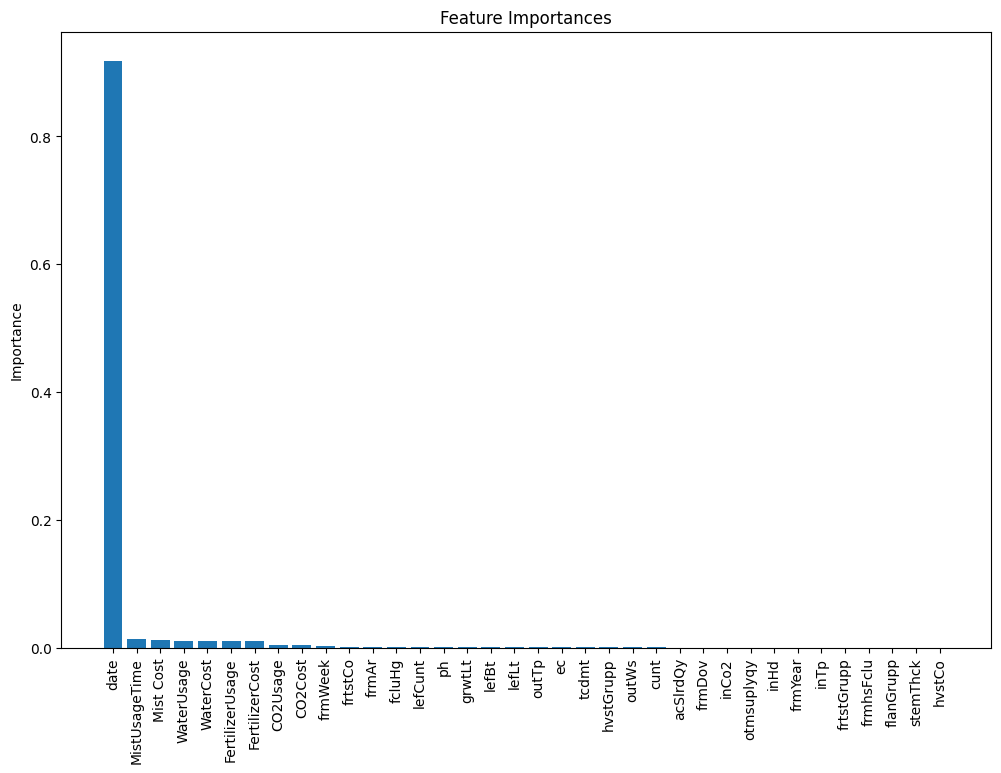

In [313]:
import matplotlib.pyplot as plt

# 피처 중요도 가져오기
feature_importances = model.feature_importances_

# 중요도 순으로 정렬
sorted_idx = feature_importances.argsort()[::-1]  # 내림차순으로 변경

# 중요도를 시각화
plt.figure(figsize=(12, 8))
plt.bar(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.ylabel('Importance')
plt.xticks(rotation=90)  # X축 레이블을 90도 회전하여 보기 좋게 만듭니다.
plt.title('Feature Importances')
plt.show()

# 성능 평가

In [314]:
# Calculate RMSE between the predictions and actual 'y' values
def calculate_rmse(targets, predictions):
    """
    Calculate the Root Mean Squared Error (RMSE) between predicted and target values.

    :param predictions: Predicted values.
    :type predictions: array-like
    :param targets: Target values.
    :type targets: array-like
    :return: RMSE value.
    :rtype: float
    """
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(targets, predictions))


# Calculate r2_score between the predictions and actual 'y' values
def calculate_R2_score(y_test,y_pred):
    from sklearn.metrics import r2_score
    return r2_score(y_test, y_pred)


rmse = calculate_rmse(y_test, y_pred)
r2score = calculate_R2_score(y_test, y_pred)

# ------------------------------------------------
### OUTPUT ###
print("RMSE:", rmse)
print("R2_score:", r2score)

RMSE: 32681.894056635512
R2_score: 0.9940656660989127
